In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import default_rng
rng = default_rng()


In [98]:
#df = pd.read_csv("../results/ab-main-main-2022-08-25T12:21:39+02:00/combined-results.csv")
df = pd.read_csv("../results/ab-main-perf-issue-request-id-2022-08-25T15:13:38+02:00/combined-results.csv")
df["version_scenario"] = df["version"] + "_" + df["scenario"]
df

,version,index,period,width,scenario,method,path,request_time_median,request_count,version_scenario
0,v1,0,1661433310000,1612,searchAndBookFlight,GET,/flights,6.0,1,v1_searchAndBookFlight
1,v1,0,1661433310000,1612,searchFlights,GET,/destinations,13.1,12,v1_searchFlights
2,v1,0,1661433310000,1612,searchAndBookFlight,GET,/destinations,7.9,4,v1_searchAndBookFlight
3,v1,0,1661433310000,1612,searchFlights,GET,/flights,7.0,8,v1_searchFlights
4,v1,1,1661433320000,9991,searchAndBookFlight,GET,/flights/$flightID/seats,2.0,41,v1_searchAndBookFlight
...,...,...,...,...,...,...,...,...,...,...
1459,v2,127,1661434580000,9997,searchFlights,GET,/flights,3752.7,667,v2_searchFlights
1460,v2,127,1661434580000,9997,searchFlights,GET,/destinations,8352.0,215,v2_searchFlights
1461,v2,127,1661434580000,9997,searchAndBookFlight,GET,/flights,4867.0,158,v2_searchAndBookFlight
1462,v2,127,1661434580000,9997,searchAndBookFlight,GET,/flights/$flightID/seats,2725.0,148,v2_searchAndBookFlight


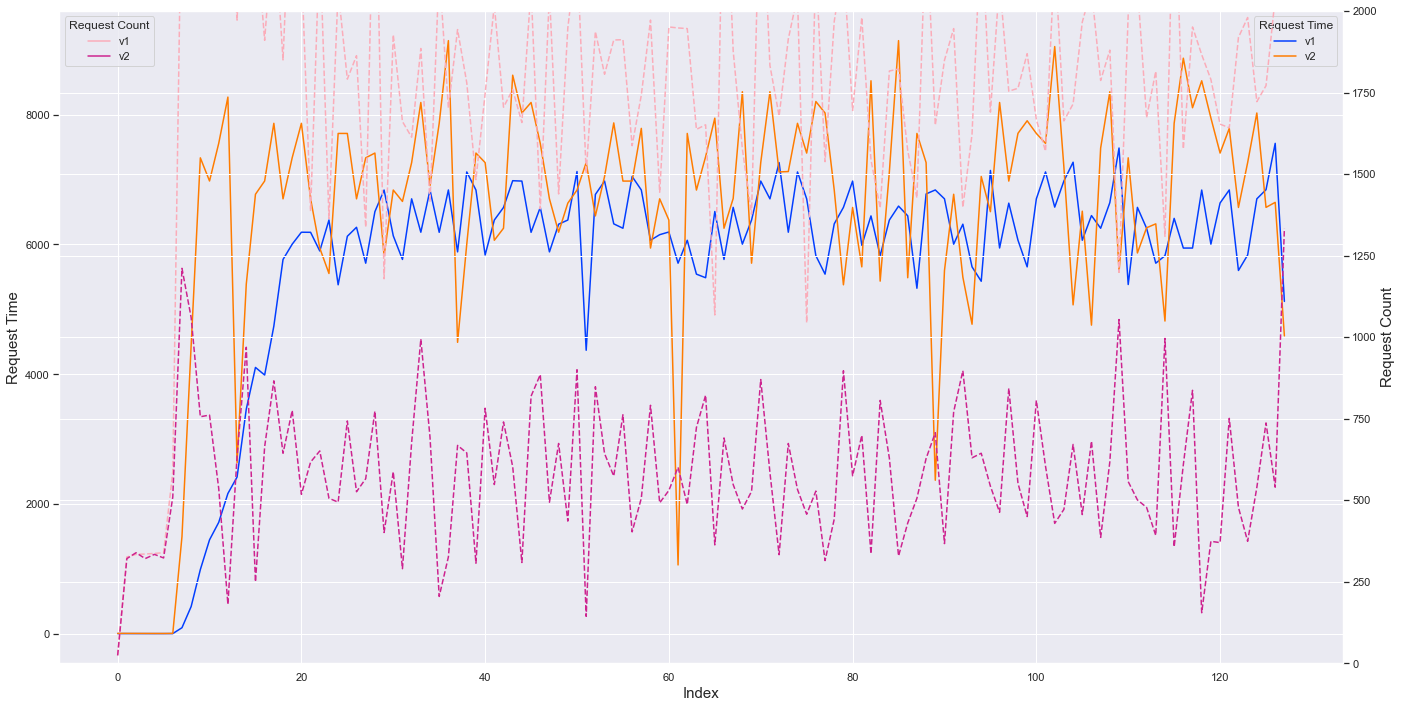

In [102]:

df_plot = df.groupby(['index', 'version']).agg({'request_time_median': 'median', 'request_count': 'sum'}).reset_index()

paletteTime = sns.color_palette("bright", 2)
paletteCount = sns.color_palette("RdPu", 2)

sns.set(rc={'figure.figsize':(23,12)})
g = sns.lineplot(data = df_plot, x='index', y='request_time_median', hue='version', palette=paletteTime)
g.set_xlabel("Index", fontsize = 15)
g.set_ylabel("Request Time", fontsize = 15)
#g.set_ylim([0, 80])
g.legend(title="Request Time")
ax2 = g.twinx()
ax2.set_ylabel("Request Count", fontsize = 15)
ax2.set_ylim([0, 2000])
g2 = sns.lineplot(data = df_plot, x='index', y='request_count', hue='version', ax=ax2, palette=paletteCount, linestyle="--")
g2.legend(title="Request Count", loc = 'upper left')

In [ ]:


# def bootstrap(perfRuntimes1: pd.DataFrame, perfRuntimes2: pd.DataFrame):
#   numberOfIterations = 5
#   instanceRunsNumber = 3
#   instanceRuns = range(1, instanceRunsNumber)
#   suiteRunsNumber = 3
#   suiteRuns = range(1,suiteRunsNumber)
#   numberOfSamples = 10000
#   allRuntimes1 = np.ndarray((instanceRunsNumber, suiteRunsNumber, numberOfIterations))
#   allRuntimes2 = np.ndarray((instanceRunsNumber, suiteRunsNumber, numberOfIterations))
#
#   for instanceRun in instanceRuns:
#     for suiteRun in suiteRuns:
#         prefix = f"{instanceRun}-{suiteRun}-"
#         allRuntimes1[instanceRun][suiteRun] = perfRuntimes1.loc[(perfRuntimes1['R-S-I'].str.startswith(prefix)),'sec/op'].to_numpy()
#         allRuntimes2[instanceRun][suiteRun] = perfRuntimes2.loc[(perfRuntimes2['R-S-I'].str.startswith(prefix)),'sec/op'].to_numpy()
#
#   #Generate random arrays
#   currentInstanceRun = rng.choice(instanceRuns, size=(instanceRunsNumber, numberOfSamples))
#   currentSuiteRun = rng.choice(suiteRuns, size=(suiteRunsNumber, instanceRunsNumber, numberOfSamples))
#   currentRuntimes1 = rng.integers(numberOfIterations, size=(numberOfIterations, suiteRunsNumber, instanceRunsNumber, numberOfSamples))
#   currentRuntimes2 = rng.integers(numberOfIterations, size=(numberOfIterations, suiteRunsNumber, instanceRunsNumber, numberOfSamples))
#
#   #Bulk selection
#   tmp1 = allRuntimes1[currentInstanceRun, currentSuiteRun, currentRuntimes1]
#   tmp1 = np.stack(tmp1, axis=3).reshape((numberOfSamples, suiteRunsNumber * instanceRunsNumber * numberOfIterations))
#   tmp2 = allRuntimes2[currentInstanceRun, currentSuiteRun, currentRuntimes2]
#   tmp2 = np.stack(tmp2, axis=3).reshape((numberOfSamples, suiteRunsNumber * instanceRunsNumber * numberOfIterations))
#
#   # Get median for both lists
#   med1 = np.median(tmp1, axis=1)
#   med2 = np.median(tmp2, axis=1)
#   R = med2/med1
#   R.sort()
#
#   CIsmall = 1 # 99% confidence interval
#   small = int((numberOfSamples * CIsmall) / 100 / 2)
#   if small == 0: small = 1
#   minSmall = R[small-1]
#   minSmall = (minSmall - 1) * 100
#   maxSmall = R[numberOfSamples-small-1]
#   maxSmall = (maxSmall - 1) * 100
#   instability = maxSmall - minSmall
#   return minSmall, maxSmall, instability

In [2]:
# def compareVersionsForBenchmark(fnName: str):
#     foundBenchmark = df[df["package.BenchmarkFunction"] == fnName]
#     runtimes1 = foundBenchmark[foundBenchmark["Version"] == 1]
#     runtimes2 = foundBenchmark[foundBenchmark["Version"] == 2]
#     assert runtimes1.shape[0] == 45
#     assert runtimes2.shape[0] == 45
#     median1 = runtimes1['sec/op'].median()
#     median2 = runtimes2['sec/op'].median()
#     change = ((median2/median1) - 1) * 100
#     minci, maxci, instability = bootstrap(runtimes1, runtimes2)
#     assert maxci > change
#     assert change > minci
#     print(f"[{fnName}] performance change: {change:.2f}% [{minci:.2f} - {maxci:.2f}] ({instability:.2f}%)")

In [ ]:
# columnNames = ["R-S-I", "package.BenchmarkFunction", "Version", "Directory", "Iterations", "sec/op", "B/op", "allocs/op"]
#
# #df = pd.read_csv("../results/fbs/mb-main-perf-issue-clean-path-2022-08-23T18:23:34+02:00.csv", names=columnNames)
# df = pd.read_csv("../results/fbs/mb-main-perf-issue-request-id-2022-08-23T19:44:15+02:00.csv", names=columnNames)
# functionNames = df["package.BenchmarkFunction"].unique()
# functionNames.sort()
#
# for fnName in functionNames:
#     compareVersionsForBenchmark(fnName)

NameError: name 'pd' is not defined